# Binary Classification of Fake or Real News


Using kaggle's dataset of "Fake and real news dataset", taken from ISOT News Dataset (https://www.uvic.ca/ecs/ece/isot/datasets/fake-news/index.php), we are trying to classify the authenticity of news recorded since 2015 to 2018. 

This dataset was scraped through reuters.com (real news) and politifact.com (fake news) by University of Victoria.

We are using various methods of tokenization and machine learning algorithms to show which algorithms can give the most satisfying result to classify fake or real news.

1. Data preparation
2. Visualization
3. Creating models
- Using tf-idf
    * SVM
    * Decision Tree
    * Random Forest
    * XGBoost
- Using GloVe
    * LSTM



The division of responsibility is as follow,

* Yifan is responsible for all the data preparation and visualization,

* Yilang is responsible for creating model using TF-IDF

* Kaicheng is responsible for creating model using GloVe, and LSTM


Although each of our member has their own responsibilty, we often exchange suggestion and always ask one another if there is any confusion.

``Importing packages``

In [1]:
# !pip install nltk
# !pip install plotly
# !pip install wordcloud
# !pip install tensorflow
# !pip install xgboost
# !pip install datasets
# !pip install transformers[torch]


In [1]:
import os
import pandas as pd
import numpy as np
import re
import string

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.figure_factory as ff
from wordcloud import WordCloud

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, fbeta_score, roc_auc_score,roc_curve,auc

## Data Preparation

This data is prepared by Yifan while considering the usage of the data on every model/method we are preparing

``Importing our datasets``

In [14]:
path = 'dataset'

fake = pd.read_csv(os.path.join(path, 'Fake.csv'))
real = pd.read_csv(os.path.join(path, 'True.csv'))

In [15]:
real.head()

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


We noticed that the first 5 texts of real news have "(Reuters)" and a city name in front of it.

In [16]:
fake.head()

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


However, this is not the case for fake news. Let's find out how many of real news contain "(Reuters)" tag in it.

In [17]:
print("Real news with 'Reuters': " + str(real.text.str.contains("\(Reuters\) - ").sum()) +"/" + str(real.shape[0]) + ", " + str(real.text.str.contains("\(Reuters\) -").mean()*100)+"%")
print("Fake news with 'Reuters': " + str(fake.text.str.contains("\(Reuters\) - ").sum()) +"/" + str(fake.shape[0]) + ", " + str(fake.text.str.contains("\(Reuters\) -").mean()*100)+"%")

Real news with 'Reuters': 21246/21417, 99.20156884717748%
Fake news with 'Reuters': 0/23481, 0.0%


This can be bad for our machine learning model, as our model can be biased towards the "(Reuters)" word --> if it contains "(Reuters)", predict real news.

Let's see what happens if we predict False (real news) when the text contains "(Reuters)"


``Combining real and fake news data to 1 DataFrame``

In [18]:
fake_with_label = fake.assign(is_fake = 1)
real_with_label = real.assign(is_fake = 0)

data = pd.concat([real_with_label,fake_with_label],axis=0,ignore_index=True) 

In [19]:
no_reuters = ~data.text.str.contains("\(Reuters\) - ")

Accuracy score: 99.61913670987572%

Confusion matrix: 


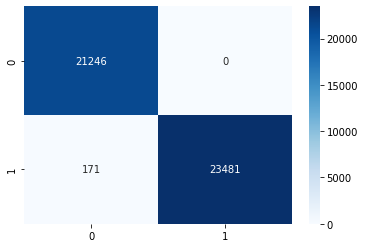

In [20]:
cf_matrix = confusion_matrix(no_reuters, data['is_fake'])

sns.heatmap(cf_matrix, annot=True, cmap='Blues', fmt = "d")

print("Accuracy score: "+str(accuracy_score(no_reuters, data['is_fake'])*100) + "%")
print("\nConfusion matrix: ")

We can obtain 99.6% accuracy with only that condition. Therefore, we need to delete "(Reuters)" if it appears in the first 5 words of the text, delete it and the city name preceding it.

To do this, we are using regex, which is '.\*\\(Reuters\) - ', meaning everything before and the word '(Reuters) - '. The function below deletes the words according to the regex in data['text'].

``Removing the words``

In [21]:
data = data.replace(to_replace = r'.*\(Reuters\) - ', value = '', regex = True)

# Exported to save time running the program
data.to_csv(os.path.join(path,"data.csv"))

# Load exported file
data = pd.read_csv(os.path.join(path,"data.csv"))


data.head()

,Unnamed: 0,title,text,subject,date,is_fake
0,0,"As U.S. budget fight looms, Republicans flip t...",The head of a conservative Republican faction ...,politicsNews,"December 31, 2017",0
1,1,U.S. military to accept transgender recruits o...,Transgender people will be allowed for the fir...,politicsNews,"December 29, 2017",0
2,2,Senior U.S. Republican senator: 'Let Mr. Muell...,The special counsel investigation of links bet...,politicsNews,"December 31, 2017",0
3,3,FBI Russia probe helped by Australian diplomat...,Trump campaign adviser George Papadopoulos tol...,politicsNews,"December 30, 2017",0
4,4,Trump wants Postal Service to charge 'much mor...,President Donald Trump called on the U.S. Post...,politicsNews,"December 29, 2017",0


Great! We successfully removed a huge exploit to our model. 

Another problem that usually happens is empty/null values in our dataset. Let's check if there are any.

In [ ]:
data = data.replace(to_replace = r'U.S.', value = 'U.S.A.', regex = True)
data.head()

``Checking empty values``

In [ ]:
data.isnull().sum()

Seems like there are no empty values in our dataset.

Another problem that usually occurs is duplicates in our dataset. Let's check if there are any.

``Checking duplicates``

In [ ]:
duplicates_text = data[data.duplicated(subset = ['text'])]
duplicates_title = data[data.duplicated(subset = ['title'])]

print("Duplicates in text: " + str(duplicates_text.shape[0]) + "/" + str(data.shape[0]))
print("Duplicates in title: " + str(duplicates_title.shape[0]) + "/" + str(data.shape[0]))

There are quite a lot of duplicates in our dataset. After splitting into train and test set, these duplicates in our train set can leak to our test set. Hence, we need to remove them.

``Removing duplicates``

In [ ]:
data = data.drop_duplicates(subset = ['text'])
data = data.drop_duplicates(subset = ['title'])

data.shape

We successfully removed the duplicates in our dataset. Now we need to drop the subject and date column since we only want to classify the news based on the title and the article. We are still keeping them in separate variable for visualization.

``Dropping columns``

In [ ]:
data_cleaned = data.drop(columns = ['subject', 'date'])
data_cleaned["article"] = data_cleaned["title"] + data_cleaned["text"]
data_cleaned.to_csv(path+"data_cleaned.csv", index = False)

full_data = data

data_cleaned = pd.read_csv(path+"data_cleaned.csv")

In [ ]:
data_cleaned.head()

This data is now ready to be visualized. We also need to split our data for training and testing.

In [ ]:
def review_cleaning(text):
    '''Make text lowercase, remove text in square brackets,remove links,remove punctuation
    and remove words containing numbers.'''
    text = str(text).lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

In [ ]:
data_cleaned['article']=data_cleaned['article'].apply(lambda x:review_cleaning(x))
data_cleaned.head()

In [ ]:
nltk.download('stopwords')

stop = stopwords.words('english')
data_cleaned['article'] = data_cleaned['article'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

data_cleaned.head()

In [ ]:
import nltk
nltk.download('omw-1.4')
nltk.download('wordnet')

lemma = WordNetLemmatizer()
lem = lambda x: ' '.join(list(map(lemma.lemmatize, x.split())))
data_cleaned['article'] = data_cleaned['article'].apply(lem)

data_cleaned.head()

In [ ]:
data_cleaned = pd.read_csv(os.path.join(path, 'data_cleaned.csv'))

data_cleaned = data_cleaned[~data_cleaned.article.isnull()]
data_cleaned.shape

data_cleaned.to_csv(os.path.join(path, 'data_cleaned.csv'), index = False)

data_cleaned.shape

Our data is now cleaned.

``Splitting data``

We are splitting our data to 80% training and 20% test set.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(data_cleaned[['article']], data_cleaned[['is_fake']], test_size = 0.2, stratify = data_cleaned[['is_fake']], random_state = 100)

In [ ]:
X_train.shape, y_train.shape

In [ ]:
X_test.shape, y_test.shape

## Visualization

Now we need to visualize our data. We will start by the count of fake and real news in our dataset.

In [ ]:
bar_type_df = pd.DataFrame({'Type': ['Real', 'Fake'], 'Count': [full_data[full_data['is_fake'] == 0].count()[0], full_data[full_data['is_fake'] == 1].count()[0]]}) 

fig = px.bar(bar_type_df, x = "Type", y = "Count", color = "Count")
fig.show()

Ratio of "Real":"Fake" is 20821:17449, which is around 1.19:1. Pretty good for our dataset as it is not too imbalanced.

Counting our dataset by its subjects

In [ ]:
bar_subject_df=full_data.groupby(['subject', 'is_fake']).apply(lambda x:x['title'].count()).reset_index(name='Counts')
fig=px.bar(bar_subject_df,x='subject',y='Counts',color='is_fake',title='Count of News Articles by Subject')
fig.show()

Now, we want to see when our news articles are posted.

In [ ]:
line_date_df=full_data.groupby(['date', 'is_fake']).apply(lambda x:x['title'].count()).reset_index(name='Counts')

line_date_df = (line_date_df[line_date_df.date.str.contains("Jan|Feb|Mar|Apr|May|Jun|Jul|Sep|Oct|Nov|Dec")])
line_date_df['date'] = pd.to_datetime(line_date_df.date)

line_date_df = line_date_df.sort_values(by='date')

line_date_df.head()

In [ ]:
fig = px.line(line_date_df, x = "date", y = "Counts", color = "is_fake")
fig.show()

We want to see the wordcloud of our fake and real news.

In [ ]:
def generate_word_cloud(text):
    wordcloud = WordCloud(
        width = 3000,
        height = 2000,
        background_color = 'black').generate(str(text))
    fig = plt.figure(
        figsize = (40, 30),
        facecolor = 'k',
        edgecolor = 'k')
    plt.imshow(wordcloud, interpolation = 'bilinear')
    plt.axis('off')
    plt.tight_layout(pad=0)
    plt.show()

``Real News WordCloud``

In [ ]:
generate_word_cloud(data_cleaned[data_cleaned.is_fake == 0].article.values)

``Fake News WordCloud`` 

In [ ]:
generate_word_cloud(data_cleaned[data_cleaned.is_fake == 1].article.values)

Now, we will visualize our article's length to determine the max length, especially for GloVe

In [ ]:
word_count = data_cleaned
word_count['word count'] = data_cleaned['article'].str.split().str.len()

fig = px.histogram(word_count, x="word count")
fig.show()

As we can see from the histogram, 250 as our word length is sufficient without sacrificing our model's robustness.

## Creating models

``Baseline Model``

In [ ]:
print(20821/38265*100)

Since there sre 54.41% of real news, we can set our baseline model to 54.41%. If our model could pass this baseline model, it means that it has successfully learned to classify our dataset.

### TF-IDF

``Importing the required library``

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.metrics import classification_report

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(data_cleaned['article'], data_cleaned['is_fake'], test_size = 0.2, stratify = data_cleaned[['is_fake']], random_state = 100)

In [ ]:
def get_prediction(vectorizer, classifier, X_train, X_test, y_train, y_test):
    pipe = Pipeline([('vector', vectorizer),
                    ('model', classifier)])
    model = pipe.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print("Accuracy: {}".format(round(accuracy_score(y_test, y_pred)*100,2)))
    cm = confusion_matrix(y_test, y_pred)
    print("Confusion Matrix: \n", cm)
    return float(accuracy_score(y_test, y_pred))
    
def final_prediction(vectorizer, classifier, X_train, X_test, y_train, y_test):
    pipe = Pipeline([('vector', vectorizer),
                    ('model', classifier)])
    model = pipe.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print("Accuracy: {}".format(round(accuracy_score(y_test, y_pred)*100,5)))
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot = True, fmt=".0f", annot_kws={"size": 18})
    plt.show()
    print("Classification Report: \n", classification_report(y_test, y_pred))

#### SVM

In [ ]:
accuracy = 0.0
tmp_accuracy = 0.0
best_c=0
c_list= [ 0.1,0.5,0.9, 1.0, 1.1]


for c in c_list :
  tmp_accuracy = get_prediction(TfidfVectorizer(), LinearSVC(C =c, random_state = 100), X_train, X_test, y_train, y_test)
  if tmp_accuracy > accuracy:
    accuracy = tmp_accuracy     
    best_c=c

print ("--------------------------------------------------------------------------------------------")
print("After trying several number of C possibilities, the fittest C parameter for this data is C =", best_c)
final_prediction(TfidfVectorizer(), LinearSVC(C =best_c), X_train, X_test, y_train, y_test)


#### Decision Tree

In [ ]:
accuracy = 0
tmp_accuracy = 0
best_depth=0
depth_list= [10,30,50,100]


for depth in depth_list :
  tmp_accuracy = get_prediction(TfidfVectorizer(), DecisionTreeClassifier(max_depth = depth, random_state = 100), X_train, X_test, y_train, y_test)
  if tmp_accuracy > accuracy:
    accuracy=tmp_accuracy
    best_depth=depth

print ("--------------------------------------------------------------------------------------------")
print("After trying several number of depth possibilities, the fittest depth parameter for this data is depth =", best_depth)
final_prediction(TfidfVectorizer(), DecisionTreeClassifier(max_depth = best_depth, random_state = 100), X_train, X_test, y_train, y_test)

#### Random Forest

In [ ]:
accuracy = 0
tmp_accuracy = 0
best_n_tree=0
n_trees= [100,200,300]


for n_tree in n_trees :
  tmp_accuracy = get_prediction(TfidfVectorizer(), RandomForestClassifier(n_estimators = n_tree, max_depth = best_depth, random_state = 100), X_train, X_test, y_train, y_test)
  if tmp_accuracy > accuracy:
    accuracy=tmp_accuracy
    best_n_tree=n_tree

print ("--------------------------------------------------------------------------------------------")
print("After trying several number of trees possibilities, the fittest n_estimators parameter for this data is = ", best_n_tree)
final_prediction(TfidfVectorizer(), RandomForestClassifier(n_estimators = best_n_tree, max_depth = best_depth, random_state = 100), X_train, X_test, y_train, y_test)

#### XGBoost

In [ ]:
accuracy = 0
tmp_accuracy = 0
best_n_tree=0
n_tree_list= [100, 200, 300, 500]


for n_tree in n_tree_list :
  tmp_accuracy = get_prediction(TfidfVectorizer(), XGBClassifier(max_depth = best_depth, n_estimators = n_tree, random_state = 100), X_train, X_test, y_train, y_test)
  if tmp_accuracy > accuracy:
    accuracy=tmp_accuracy
    best_n_tree=n_tree

print ("--------------------------------------------------------------------------------------------")
print("After trying several number of trees possibilities, the fittest n_estimators parameter for this data is =", n_tree)
final_prediction(TfidfVectorizer(), XGBClassifier(max_depth = best_depth, n_estimators = best_n_tree, random_state = 100), X_train, X_test, y_train, y_test)

Although in each of the model it seems that we only try on 4 values on the parameters, we have actually tried more than that, however, in order to save the running time we only put 4 different values on each parameters to show the contrast and that twitching the values will give us a better result.

### GloVe

An unsupervised learning algorithm used to obtain vector representation of words

``Importing the required library``

In [22]:
import os
import pandas as pd
import numpy as np
import re
import string
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.figure_factory as ff
from wordcloud import WordCloud

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, fbeta_score, roc_auc_score,roc_curve,auc
import tensorflow as tf
from tensorflow.keras.layers import LSTM, GRU, Dense, Embedding, Dropout
from tensorflow.keras.preprocessing import text, sequence 
from tensorflow.keras.models import Sequential
from sklearn.model_selection import KFold

In [23]:
path = 'dataset'
data_cleaned = pd.read_csv(os.path.join(path, 'data_cleaned.csv'))
kfold = KFold(n_splits=5, shuffle=True)
#X_train, X_test, y_train, y_test = train_test_split(data_cleaned[['article']], data_cleaned[['is_fake']], test_size = 0.2, stratify = data_cleaned[['is_fake']], random_state = 100)

#### Tokenize + Padding

Tokenizer finds the frequency of each unique word and sort them based on their frequency. Then, it will assign an integer value (starting from 1) to each word from the top.

In [24]:
'''xtrain_values = X_train['article'].values
xtest_values = X_test['article'].values'''
data_values = data_cleaned['article'].values

In [25]:
max_len = 250

In [28]:
max_words = 10000
tokenizer = text.Tokenizer(num_words=max_words)

'''# Fit tokenizer on our training data set to create the word indices
tokenizer.fit_on_texts(xtrain_values)

# Using word index from fit_on_texts step, we transform both train & test data set
X_train_seq = tokenizer.texts_to_sequences(xtrain_values)
X_test_seq = tokenizer.texts_to_sequences(xtest_values)

# Add padding to the sequence
X_train_pad = sequence.pad_sequences(X_train_seq, maxlen = max_len)
X_test_pad = sequence.pad_sequences(X_test_seq, maxlen = max_len)'''
tokenizer.fit_on_texts(data_values)
data_seq = tokenizer.texts_to_sequences(data_values)
data_pad = sequence.pad_sequences(data_seq, maxlen = max_len)
word_index = tokenizer.word_index


In [29]:
print("Text example:", data_values[0])
print("Sequence of indices (before add padding): ", data_seq[0])
print("Sequence of indices (after add padding): ", data_pad[0])

Text example: usa budget fight loom republican flip fiscal scriptthe head conservative republican faction usa congress voted month huge expansion national debt pay tax cut called “fiscal conservative” sunday urged budget restraint keeping sharp pivot way among republican usa representative mark meadow speaking cbs’ “face nation” drew hard line federal spending lawmaker bracing battle january return holiday wednesday lawmaker begin trying pas federal budget fight likely linked issue immigration policy even november congressional election campaign approach republican seek keep control congress president donald trump republican want big budget increase military spending democrat also want proportional increase nondefense “discretionary” spending program support education scientific research infrastructure public health environmental protection “the trump administration already willing say ‘we’re going increase nondefense discretionary spending percent’” meadow chairman small influential h

#### Word Embedding using pre-trained GloVe vectors

Represent words with similar meaning to have similar representation

(GloVe pre-trained word vectors via: https://nlp.stanford.edu/projects/glove/)


Load the GloVe vectors

In [30]:
glovetxt = os.path.join(path, 'glove.6B.100d.txt')

In [32]:
embedding_vectors = {};

with open(glovetxt, 'rb') as f:
    for line in f:
        values = line.split();
        word = values[0];
        weights = np.asarray(values[1:], dtype='float32');
        embedding_vectors[word] = weights;


In [33]:
print("Size of vocabulary in GloVe", len(embedding_vectors))

Size of vocabulary in GloVe 400000


In [39]:
embedding_vectors

{b'the': array([-0.038194, -0.24487 ,  0.72812 , -0.39961 ,  0.083172,  0.043953,
        -0.39141 ,  0.3344  , -0.57545 ,  0.087459,  0.28787 , -0.06731 ,
         0.30906 , -0.26384 , -0.13231 , -0.20757 ,  0.33395 , -0.33848 ,
        -0.31743 , -0.48336 ,  0.1464  , -0.37304 ,  0.34577 ,  0.052041,
         0.44946 , -0.46971 ,  0.02628 , -0.54155 , -0.15518 , -0.14107 ,
        -0.039722,  0.28277 ,  0.14393 ,  0.23464 , -0.31021 ,  0.086173,
         0.20397 ,  0.52624 ,  0.17164 , -0.082378, -0.71787 , -0.41531 ,
         0.20335 , -0.12763 ,  0.41367 ,  0.55187 ,  0.57908 , -0.33477 ,
        -0.36559 , -0.54857 , -0.062892,  0.26584 ,  0.30205 ,  0.99775 ,
        -0.80481 , -3.0243  ,  0.01254 , -0.36942 ,  2.2167  ,  0.72201 ,
        -0.24978 ,  0.92136 ,  0.034514,  0.46745 ,  1.1079  , -0.19358 ,
        -0.074575,  0.23353 , -0.052062, -0.22044 ,  0.057162, -0.15806 ,
        -0.30798 , -0.41625 ,  0.37972 ,  0.15006 , -0.53212 , -0.2055  ,
        -1.2526  ,  0.071624, 

**Embedding matrix with the GloVe vectors**

Embedding matrix with a shape of (vocab length, embedding dimension)

Each row of the matrix belongs to one word in the vocabulary and contains the weight of embedding vectors of the word

In [34]:
embedding_dim = 100   # size of the vector space in which words will be embedded
if max_words is not None: 
    vocab_len = max_words 
else:
    vocab_len = len(word_index)+1

# Initialize the embedding matrix with zeros
embedding_matrix = np.zeros((vocab_len, embedding_dim))

In [59]:
oov_count = 0
oov_words = []

for word, i in word_index.items():
  if i<vocab_len:
    try:
        word = word.encode('ascii')
    embedding_vector = embedding_vectors.get(word)
    if embedding_vector is not None:
      embedding_matrix[i] = embedding_vector
    # If a word in word_index is not found in the embedding_vectors from GloVe, we put it in oov_words and its weight remains 0
    else:
      oov_count+=1
      oov_words.append(word)

SyntaxError: invalid syntax (2218001503.py, line 8)

In [43]:
print("Some Out of Vocabulary words: ", oov_words[0:10])

Some Out of Vocabulary words:  ['trump’s', '“i', '“the', '“we', b'realdonaldtrump', 'obama’s', b'brexit', 'it’s', 'don’t', b'presidentelect']


In [45]:
print(f"{oov_count} out of {vocab_len} words are OOV")
y = data_cleaned['is_fake']

586 out of 10000 words are OOV


#### Modeling

##### **Model Architecture**

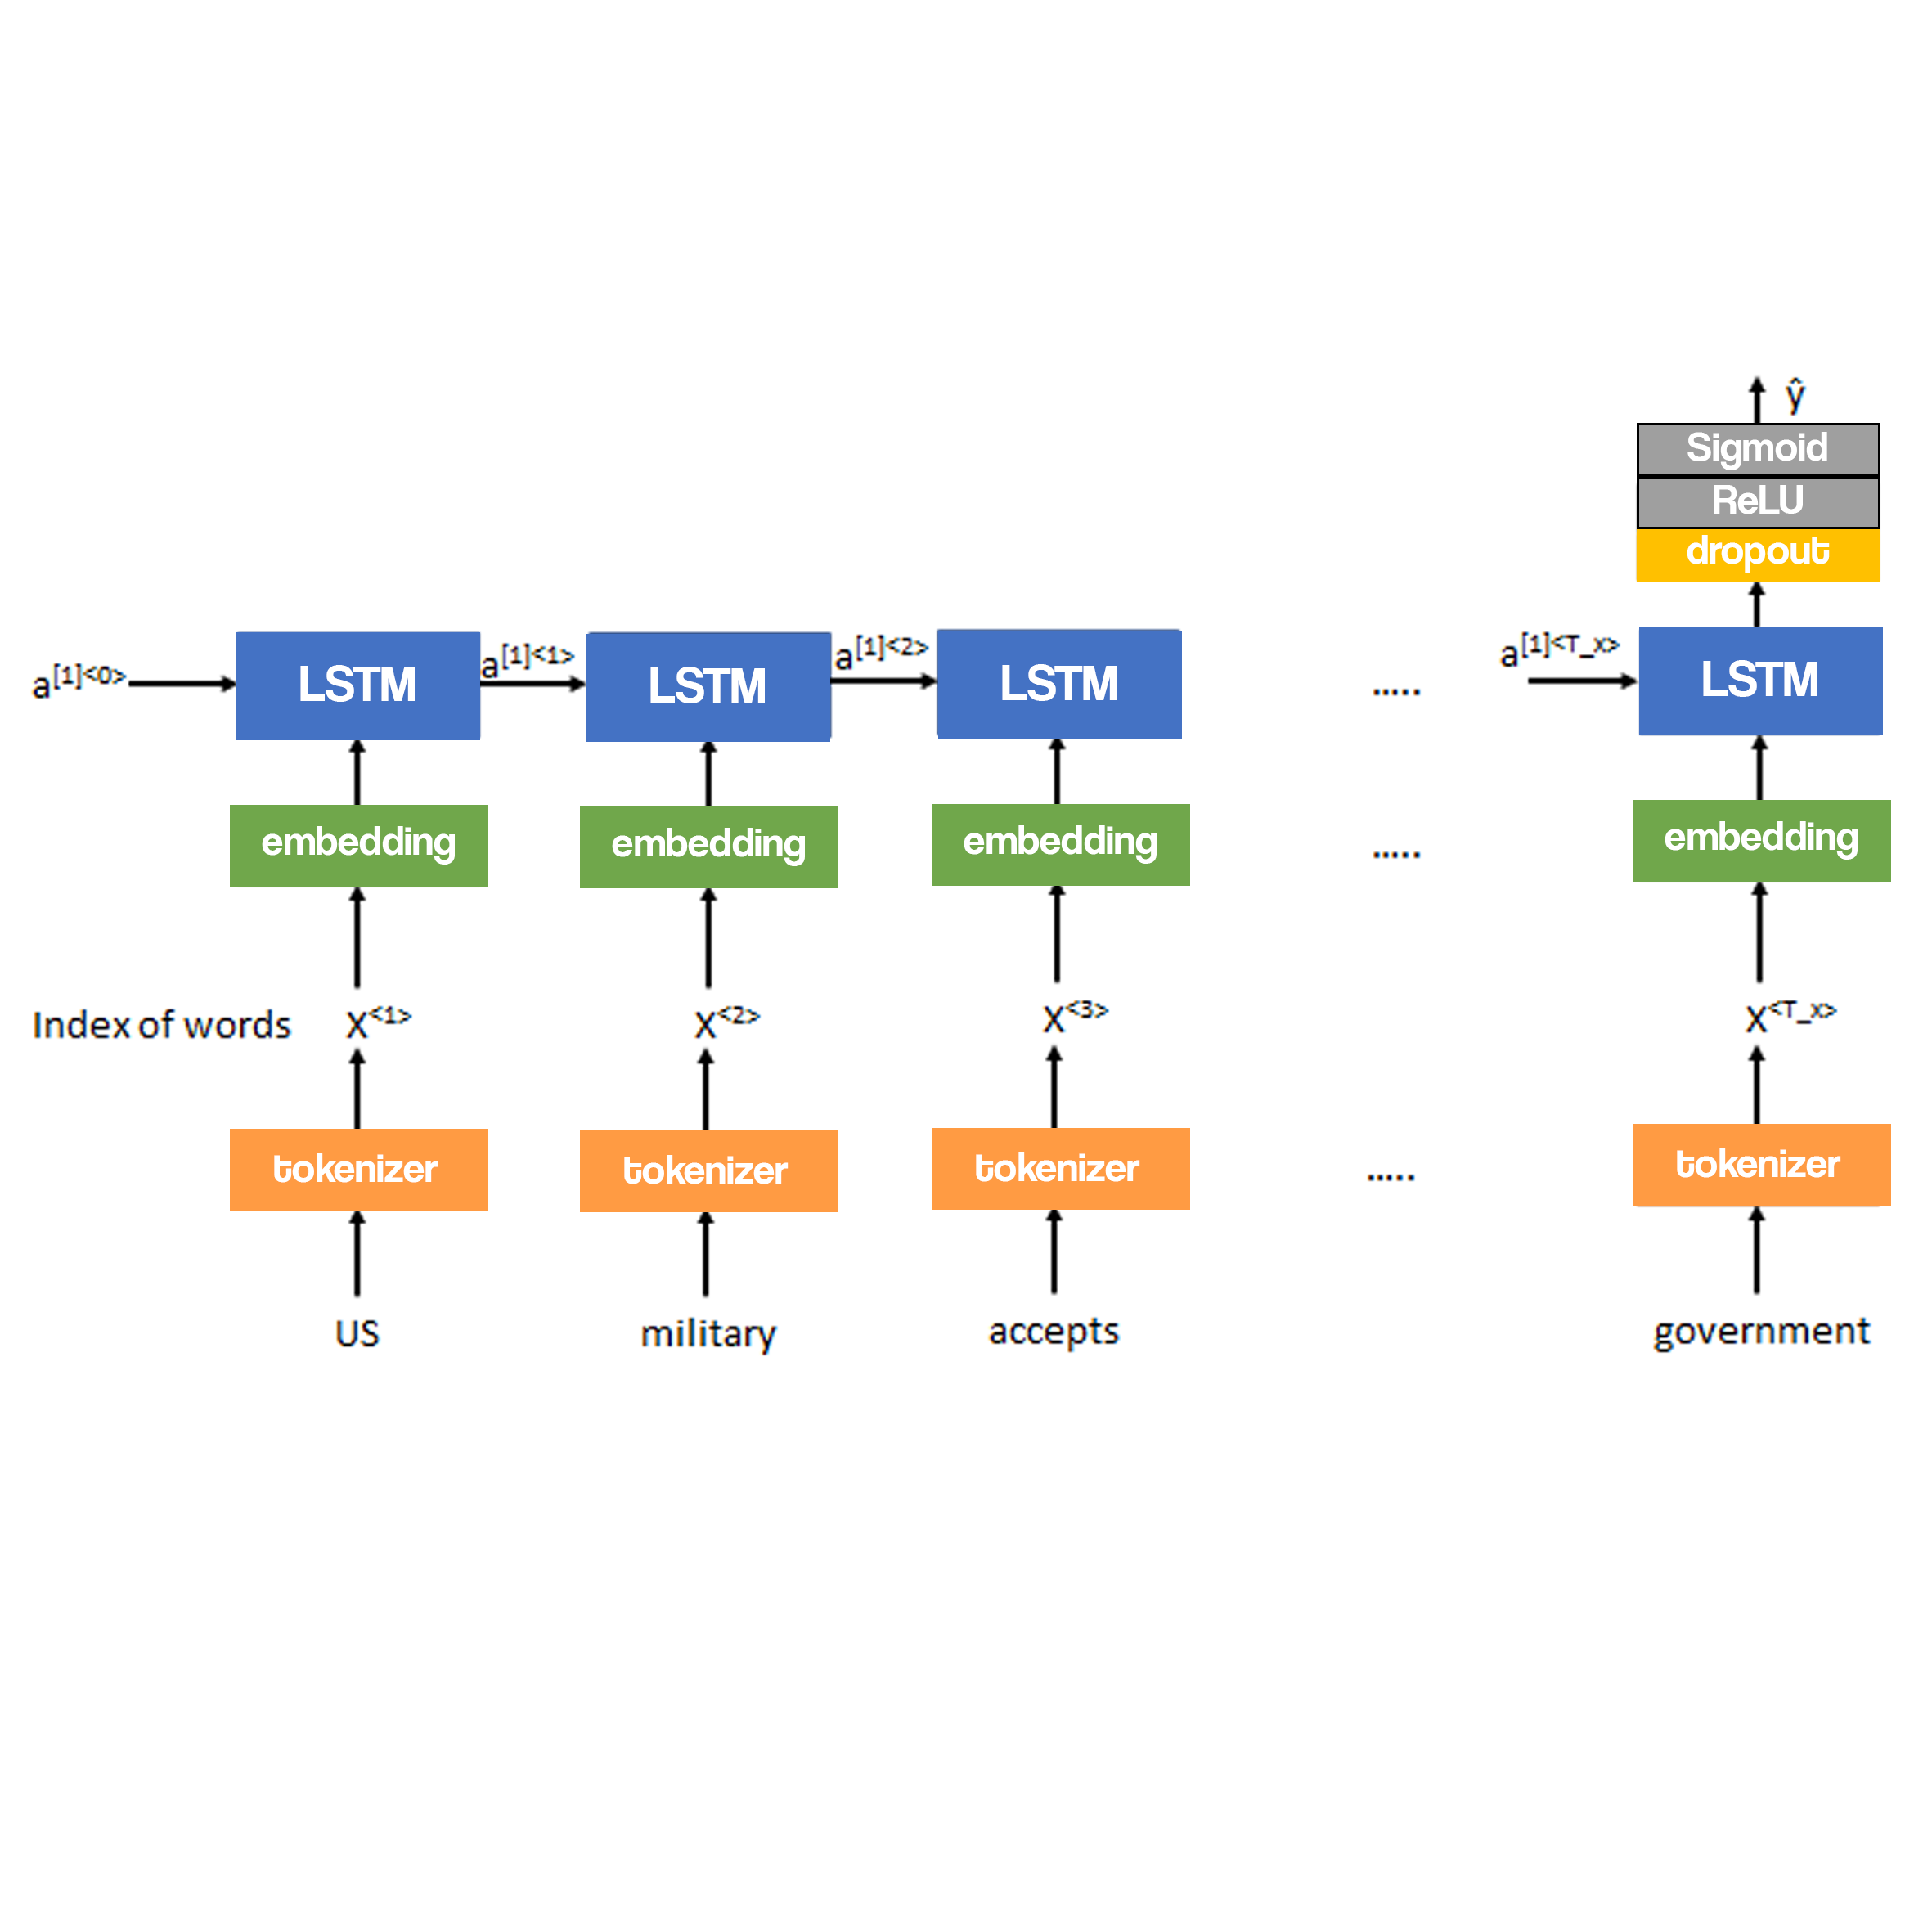

**First Layer: Embedding Layer**

It represents words using a dense vector representation. The position of a word within the vector space is based on the words that surround the word when it is used. E.g “king” is placed near “man”

In this case, we set the `weights` of the Embedding layer with embedding matrix from GloVe pre-trained vectors <br>We set the parameter `trainable` to False as we don't want the embedding weights to be updated

**Second Layer: LSTM**

Here we will use 3 different unit sizes, whicha re 64, 128, and 256. 
<br>The `return_sequences` set to be False as we don't want the output of previous LSTM layers to be used as the input in the next LSTM layers



**Third Layer: Dropout**

It is a regularizer technique that keeping it as away as possible from any bias (overfitting) by dropping out neurons at random, during every epoch
<br>Fraction of the input `unit` to drop: 0.5

**Final Layer: Dense**

It helps in changing the dimensionality of the output from the preceding layer so that the model can easily define the relationship between the values of the data in which the model is working.

We first use the ReLU (Rectified Linear Unit) activation function. The function returns 0 if it receives any negative input, but for any positive value  x  it returns that value back. So it can be written as  f(x)=max(0,x). The rectified linear activation function overcomes the vanishing gradient problem, allowing models to learn faster and perform better.

Since we are doing a Binary Classification in this case, the `activation` function is **sigmoid(x) = 1 / (1 + exp(-x))**. <br>Sigmoid function maps any input to an output ranging from **0 to 1** 
Sigmoid layer `unit` equals to 1 as the output size of the final layer


##### **LSTM with output size of 64**

In [52]:
from tensorflow import keras
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]
def plot_cm(labels, predictions, p=0.5, K=0):
    cm = confusion_matrix(labels, predictions > p)
    plt.figure(figsize=(5,5))
    sns.heatmap(cm, annot=True, fmt="d")
    plt.title('{} Fold Confusion matrix @{:.2f}'.format(K, p))
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
    plt.legend()
    plt.show()

    print('Legitimate Transactions Detected (True Negatives): ', cm[0][0])
    print('Legitimate Transactions Incorrectly Detected (False Positives): ', cm[0][1])
    print('Fraudulent Transactions Missed (False Negatives): ', cm[1][0])
    print('Fraudulent Transactions Detected (True Positives): ', cm[1][1])
    print('Total Fraudulent Transactions: ', np.sum(cm[1]))

Fit the model to the training and testing dataset

1 fold validation:
Epoch 1/15
240/240 [==============================] - 10s 29ms/step - loss: 0.2299 - tp: 16293.0000 - fp: 861.0000 - tn: 20826.0000 - fn: 1848.0000 - accuracy: 0.9320 - precision: 0.9498 - recall: 0.8981 - auc: 0.9800 - prc: 0.9787 - val_loss: 0.0999 - val_tp: 3398.0000 - val_fp: 153.0000 - val_tn: 3986.0000 - val_fn: 116.0000 - val_accuracy: 0.9649 - val_precision: 0.9569 - val_recall: 0.9670 - val_auc: 0.9931 - val_prc: 0.9929
Epoch 2/15
240/240 [==============================] - 5s 23ms/step - loss: 0.0996 - tp: 13390.0000 - fp: 509.0000 - tn: 16173.0000 - fn: 540.0000 - accuracy: 0.9657 - precision: 0.9634 - recall: 0.9612 - auc: 0.9923 - prc: 0.9918 - val_loss: 0.0707 - val_tp: 3437.0000 - val_fp: 110.0000 - val_tn: 4029.0000 - val_fn: 77.0000 - val_accuracy: 0.9756 - val_precision: 0.9690 - val_recall: 0.9781 - val_auc: 0.9963 - val_prc: 0.9961
Epoch 3/15
240/240 [==============================] - 5s 23ms/step - loss: 0.0592 - tp: 13650.0000 - fp: 313.0000 - tn

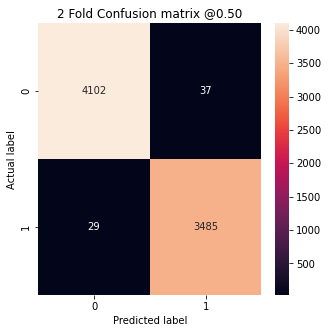

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Legitimate Transactions Detected (True Negatives):  4102
Legitimate Transactions Incorrectly Detected (False Positives):  37
Fraudulent Transactions Missed (False Negatives):  29
Fraudulent Transactions Detected (True Positives):  3485
Total Fraudulent Transactions:  3514


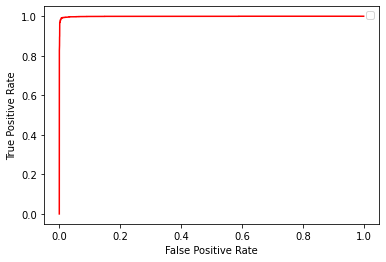

2 fold validation:
Epoch 1/15
240/240 [==============================] - 12s 32ms/step - loss: 0.2136 - tp: 15832.0000 - fp: 1006.0000 - tn: 19816.0000 - fn: 1611.0000 - accuracy: 0.9316 - precision: 0.9403 - recall: 0.9076 - auc: 0.9799 - prc: 0.9777 - val_loss: 0.1579 - val_tp: 3435.0000 - val_fp: 328.0000 - val_tn: 3810.0000 - val_fn: 80.0000 - val_accuracy: 0.9467 - val_precision: 0.9128 - val_recall: 0.9772 - val_auc: 0.9911 - val_prc: 0.9911
Epoch 2/15
240/240 [==============================] - 6s 25ms/step - loss: 0.0983 - tp: 13392.0000 - fp: 467.0000 - tn: 16216.0000 - fn: 537.0000 - accuracy: 0.9672 - precision: 0.9663 - recall: 0.9614 - auc: 0.9924 - prc: 0.9924 - val_loss: 0.0628 - val_tp: 3397.0000 - val_fp: 40.0000 - val_tn: 4098.0000 - val_fn: 118.0000 - val_accuracy: 0.9794 - val_precision: 0.9884 - val_recall: 0.9664 - val_auc: 0.9964 - val_prc: 0.9967
Epoch 3/15
240/240 [==============================] - 6s 25ms/step - loss: 0.0436 - tp: 13677.0000 - fp: 167.0000 - tn

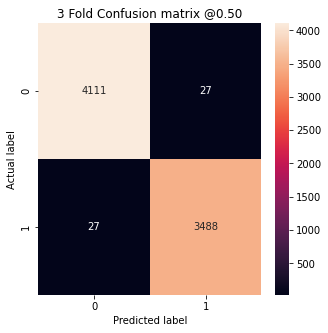

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Legitimate Transactions Detected (True Negatives):  4111
Legitimate Transactions Incorrectly Detected (False Positives):  27
Fraudulent Transactions Missed (False Negatives):  27
Fraudulent Transactions Detected (True Positives):  3488
Total Fraudulent Transactions:  3515


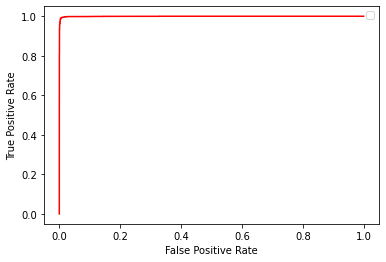

3 fold validation:
Epoch 1/15
240/240 [==============================] - 11s 30ms/step - loss: 0.2040 - tp: 16005.0000 - fp: 954.0000 - tn: 19842.0000 - fn: 1464.0000 - accuracy: 0.9368 - precision: 0.9437 - recall: 0.9162 - auc: 0.9811 - prc: 0.9799 - val_loss: 0.1200 - val_tp: 3198.0000 - val_fp: 26.0000 - val_tn: 4137.0000 - val_fn: 292.0000 - val_accuracy: 0.9584 - val_precision: 0.9919 - val_recall: 0.9163 - val_auc: 0.9891 - val_prc: 0.9907
Epoch 2/15
240/240 [==============================] - 5s 23ms/step - loss: 0.1010 - tp: 13403.0000 - fp: 570.0000 - tn: 16088.0000 - fn: 551.0000 - accuracy: 0.9634 - precision: 0.9592 - recall: 0.9605 - auc: 0.9923 - prc: 0.9918 - val_loss: 0.0747 - val_tp: 3392.0000 - val_fp: 109.0000 - val_tn: 4054.0000 - val_fn: 98.0000 - val_accuracy: 0.9730 - val_precision: 0.9689 - val_recall: 0.9719 - val_auc: 0.9966 - val_prc: 0.9965
Epoch 3/15
240/240 [==============================] - 5s 23ms/step - loss: 0.0428 - tp: 13698.0000 - fp: 173.0000 - tn:

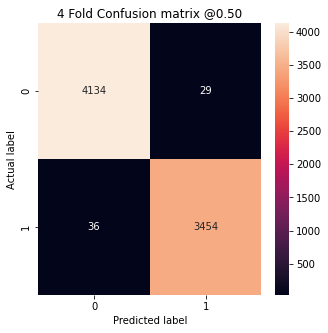

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Legitimate Transactions Detected (True Negatives):  4134
Legitimate Transactions Incorrectly Detected (False Positives):  29
Fraudulent Transactions Missed (False Negatives):  36
Fraudulent Transactions Detected (True Positives):  3454
Total Fraudulent Transactions:  3490


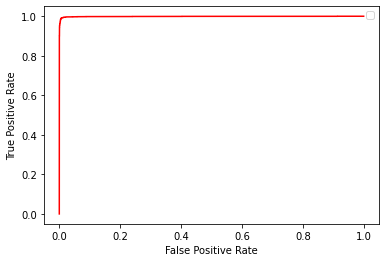

4 fold validation:
Epoch 1/15
240/240 [==============================] - 11s 31ms/step - loss: 0.2010 - tp: 15926.0000 - fp: 870.0000 - tn: 19920.0000 - fn: 1549.0000 - accuracy: 0.9368 - precision: 0.9482 - recall: 0.9114 - auc: 0.9815 - prc: 0.9799 - val_loss: 0.0906 - val_tp: 3338.0000 - val_fp: 95.0000 - val_tn: 4099.0000 - val_fn: 121.0000 - val_accuracy: 0.9718 - val_precision: 0.9723 - val_recall: 0.9650 - val_auc: 0.9940 - val_prc: 0.9930
Epoch 2/15
240/240 [==============================] - 6s 23ms/step - loss: 0.0956 - tp: 13390.0000 - fp: 373.0000 - tn: 16254.0000 - fn: 595.0000 - accuracy: 0.9684 - precision: 0.9729 - recall: 0.9575 - auc: 0.9925 - prc: 0.9923 - val_loss: 0.1132 - val_tp: 3426.0000 - val_fp: 271.0000 - val_tn: 3923.0000 - val_fn: 33.0000 - val_accuracy: 0.9603 - val_precision: 0.9267 - val_recall: 0.9905 - val_auc: 0.9957 - val_prc: 0.9935
Epoch 3/15
240/240 [==============================] - 6s 24ms/step - loss: 0.0635 - tp: 13651.0000 - fp: 260.0000 - tn:

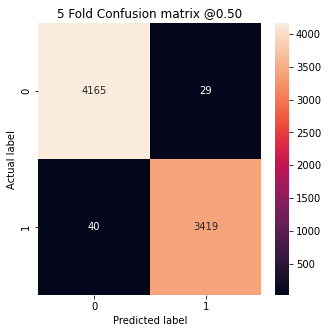

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Legitimate Transactions Detected (True Negatives):  4165
Legitimate Transactions Incorrectly Detected (False Positives):  29
Fraudulent Transactions Missed (False Negatives):  40
Fraudulent Transactions Detected (True Positives):  3419
Total Fraudulent Transactions:  3459


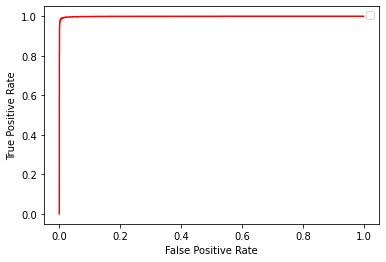

5 fold validation:
Epoch 1/15
240/240 [==============================] - 11s 30ms/step - loss: 0.2467 - tp: 15653.0000 - fp: 1452.0000 - tn: 19376.0000 - fn: 1784.0000 - accuracy: 0.9154 - precision: 0.9151 - recall: 0.8977 - auc: 0.9740 - prc: 0.9710 - val_loss: 0.1337 - val_tp: 3349.0000 - val_fp: 289.0000 - val_tn: 3898.0000 - val_fn: 117.0000 - val_accuracy: 0.9469 - val_precision: 0.9206 - val_recall: 0.9662 - val_auc: 0.9904 - val_prc: 0.9896
Epoch 2/15
240/240 [==============================] - 6s 23ms/step - loss: 0.0864 - tp: 13505.0000 - fp: 404.0000 - tn: 16230.0000 - fn: 473.0000 - accuracy: 0.9714 - precision: 0.9710 - recall: 0.9662 - auc: 0.9939 - prc: 0.9936 - val_loss: 0.0590 - val_tp: 3368.0000 - val_fp: 58.0000 - val_tn: 4129.0000 - val_fn: 98.0000 - val_accuracy: 0.9796 - val_precision: 0.9831 - val_recall: 0.9717 - val_auc: 0.9967 - val_prc: 0.9970
Epoch 3/15
240/240 [==============================] - 6s 23ms/step - loss: 0.0529 - tp: 13697.0000 - fp: 234.0000 - tn

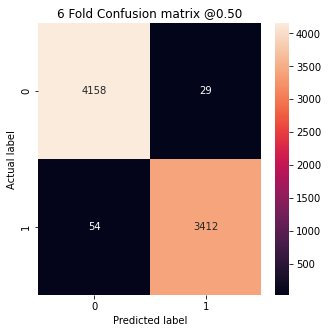

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Legitimate Transactions Detected (True Negatives):  4158
Legitimate Transactions Incorrectly Detected (False Positives):  29
Fraudulent Transactions Missed (False Negatives):  54
Fraudulent Transactions Detected (True Positives):  3412
Total Fraudulent Transactions:  3466


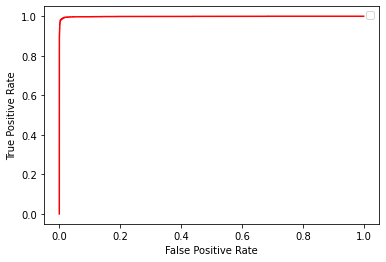

In [56]:
epochs  = 15
k = 1

for train, test in kfold.split(data_pad, y):
    print(f"{k} fold validation:")
    k += 1
    lstm_model = tf.keras.Sequential([
        tf.keras.layers.Embedding(vocab_len, embedding_dim, input_length=max_len, weights=[embedding_matrix], trainable=True),
        tf.keras.layers.LSTM(64,return_sequences=False),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dense(1, activation = 'sigmoid')
    ])

    lstm_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=METRICS)
    history = lstm_model.fit(data_pad[train], np.asarray(y[train]), epochs = epochs, validation_data=(data_pad[test], np.asarray(y[test])), batch_size=128)
    test_evaluation = lstm_model.evaluate(data_pad[test], np.asarray(y[test]), verbose=0, batch_size=256)
    test_predictions = lstm_model.predict(data_pad[test], batch_size=256)
    for name, value in zip(lstm_model.metrics_names, test_evaluation):
        print(name, ': ', value)
    print()
    plot_cm(np.asarray(y[test]), test_predictions, K=k-1)
    fpr, tpr, _ = roc_curve(np.asarray(y[test]), test_predictions)
    plt.plot(fpr, tpr, color = 'r')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    # show the legend
    plt.legend()
    # show the plot
    plt.show()

##### **LSTM with output size of 128**

1 fold validation:
Epoch 1/15
240/240 [==============================] - 12s 34ms/step - loss: 0.1687 - tp: 16205.0000 - fp: 810.0000 - tn: 20061.0000 - fn: 1189.0000 - accuracy: 0.9478 - precision: 0.9524 - recall: 0.9316 - auc: 0.9858 - prc: 0.9846 - val_loss: 0.0904 - val_tp: 3454.0000 - val_fp: 174.0000 - val_tn: 3963.0000 - val_fn: 62.0000 - val_accuracy: 0.9692 - val_precision: 0.9520 - val_recall: 0.9824 - val_auc: 0.9952 - val_prc: 0.9935
Epoch 2/15
240/240 [==============================] - 6s 25ms/step - loss: 0.0817 - tp: 13418.0000 - fp: 323.0000 - tn: 16361.0000 - fn: 510.0000 - accuracy: 0.9728 - precision: 0.9765 - recall: 0.9634 - auc: 0.9944 - prc: 0.9941 - val_loss: 0.0580 - val_tp: 3466.0000 - val_fp: 106.0000 - val_tn: 4031.0000 - val_fn: 50.0000 - val_accuracy: 0.9796 - val_precision: 0.9703 - val_recall: 0.9858 - val_auc: 0.9977 - val_prc: 0.9977
Epoch 3/15
240/240 [==============================] - 6s 25ms/step - loss: 0.0416 - tp: 13681.0000 - fp: 169.0000 - tn:

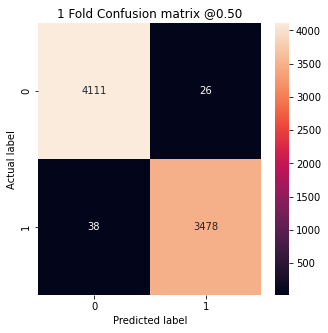

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Legitimate Transactions Detected (True Negatives):  4111
Legitimate Transactions Incorrectly Detected (False Positives):  26
Fraudulent Transactions Missed (False Negatives):  38
Fraudulent Transactions Detected (True Positives):  3478
Total Fraudulent Transactions:  3516


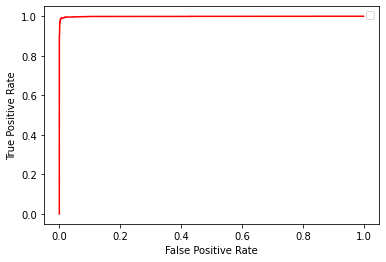

2 fold validation:
Epoch 1/15
240/240 [==============================] - 12s 36ms/step - loss: 0.2407 - tp: 15621.0000 - fp: 1066.0000 - tn: 19699.0000 - fn: 1879.0000 - accuracy: 0.9230 - precision: 0.9361 - recall: 0.8926 - auc: 0.9737 - prc: 0.9726 - val_loss: 0.1325 - val_tp: 3178.0000 - val_fp: 79.0000 - val_tn: 4114.0000 - val_fn: 282.0000 - val_accuracy: 0.9528 - val_precision: 0.9757 - val_recall: 0.9185 - val_auc: 0.9865 - val_prc: 0.9879
Epoch 2/15
240/240 [==============================] - 6s 26ms/step - loss: 0.1142 - tp: 13248.0000 - fp: 399.0000 - tn: 16229.0000 - fn: 736.0000 - accuracy: 0.9629 - precision: 0.9708 - recall: 0.9474 - auc: 0.9889 - prc: 0.9897 - val_loss: 0.0949 - val_tp: 3379.0000 - val_fp: 163.0000 - val_tn: 4030.0000 - val_fn: 81.0000 - val_accuracy: 0.9681 - val_precision: 0.9540 - val_recall: 0.9766 - val_auc: 0.9932 - val_prc: 0.9933
Epoch 3/15
240/240 [==============================] - 6s 26ms/step - loss: 0.0762 - tp: 13582.0000 - fp: 356.0000 - tn

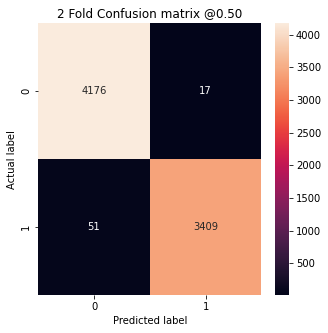

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Legitimate Transactions Detected (True Negatives):  4176
Legitimate Transactions Incorrectly Detected (False Positives):  17
Fraudulent Transactions Missed (False Negatives):  51
Fraudulent Transactions Detected (True Positives):  3409
Total Fraudulent Transactions:  3460


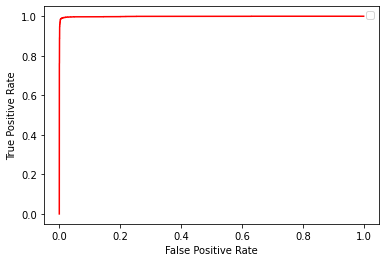

3 fold validation:
Epoch 1/15
240/240 [==============================] - 10s 30ms/step - loss: 0.1906 - tp: 16069.0000 - fp: 921.0000 - tn: 19963.0000 - fn: 1312.0000 - accuracy: 0.9416 - precision: 0.9458 - recall: 0.9245 - auc: 0.9828 - prc: 0.9816 - val_loss: 0.1086 - val_tp: 3404.0000 - val_fp: 156.0000 - val_tn: 3974.0000 - val_fn: 119.0000 - val_accuracy: 0.9641 - val_precision: 0.9562 - val_recall: 0.9662 - val_auc: 0.9922 - val_prc: 0.9921
Epoch 2/15
240/240 [==============================] - 6s 25ms/step - loss: 0.0974 - tp: 13370.0000 - fp: 393.0000 - tn: 16298.0000 - fn: 551.0000 - accuracy: 0.9692 - precision: 0.9714 - recall: 0.9604 - auc: 0.9920 - prc: 0.9919 - val_loss: 0.0951 - val_tp: 3377.0000 - val_fp: 74.0000 - val_tn: 4056.0000 - val_fn: 146.0000 - val_accuracy: 0.9713 - val_precision: 0.9786 - val_recall: 0.9586 - val_auc: 0.9933 - val_prc: 0.9937
Epoch 3/15
240/240 [==============================] - 6s 25ms/step - loss: 0.0952 - tp: 13253.0000 - fp: 305.0000 - tn

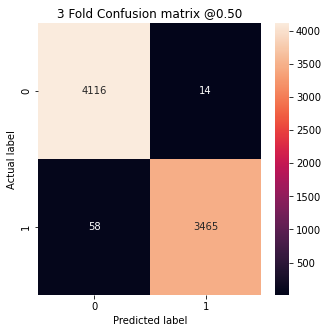

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Legitimate Transactions Detected (True Negatives):  4116
Legitimate Transactions Incorrectly Detected (False Positives):  14
Fraudulent Transactions Missed (False Negatives):  58
Fraudulent Transactions Detected (True Positives):  3465
Total Fraudulent Transactions:  3523


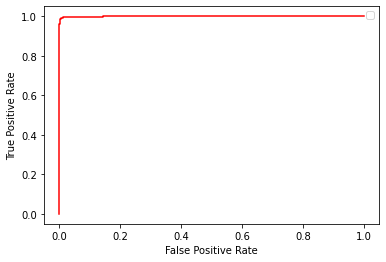

4 fold validation:
Epoch 1/15
240/240 [==============================] - 11s 34ms/step - loss: 0.1992 - tp: 16119.0000 - fp: 1073.0000 - tn: 19662.0000 - fn: 1411.0000 - accuracy: 0.9351 - precision: 0.9376 - recall: 0.9195 - auc: 0.9819 - prc: 0.9807 - val_loss: 0.1055 - val_tp: 3341.0000 - val_fp: 219.0000 - val_tn: 3997.0000 - val_fn: 96.0000 - val_accuracy: 0.9588 - val_precision: 0.9385 - val_recall: 0.9721 - val_auc: 0.9929 - val_prc: 0.9921
Epoch 2/15
240/240 [==============================] - 6s 25ms/step - loss: 0.0998 - tp: 13457.0000 - fp: 440.0000 - tn: 16165.0000 - fn: 550.0000 - accuracy: 0.9677 - precision: 0.9683 - recall: 0.9607 - auc: 0.9918 - prc: 0.9918 - val_loss: 0.0595 - val_tp: 3348.0000 - val_fp: 55.0000 - val_tn: 4161.0000 - val_fn: 89.0000 - val_accuracy: 0.9812 - val_precision: 0.9838 - val_recall: 0.9741 - val_auc: 0.9970 - val_prc: 0.9967
Epoch 3/15
240/240 [==============================] - 6s 25ms/step - loss: 0.0472 - tp: 13766.0000 - fp: 211.0000 - tn:

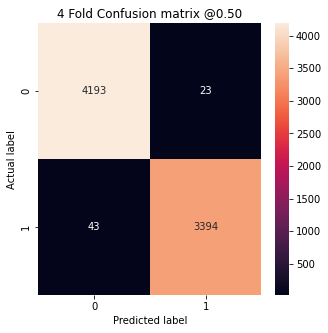

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Legitimate Transactions Detected (True Negatives):  4193
Legitimate Transactions Incorrectly Detected (False Positives):  23
Fraudulent Transactions Missed (False Negatives):  43
Fraudulent Transactions Detected (True Positives):  3394
Total Fraudulent Transactions:  3437


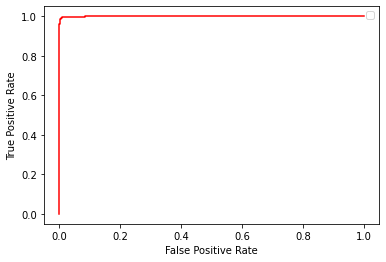

5 fold validation:
Epoch 1/15
240/240 [==============================] - 12s 35ms/step - loss: 0.2143 - tp: 15839.0000 - fp: 1068.0000 - tn: 19824.0000 - fn: 1534.0000 - accuracy: 0.9320 - precision: 0.9368 - recall: 0.9117 - auc: 0.9797 - prc: 0.9777 - val_loss: 0.1106 - val_tp: 3404.0000 - val_fp: 233.0000 - val_tn: 3912.0000 - val_fn: 104.0000 - val_accuracy: 0.9560 - val_precision: 0.9359 - val_recall: 0.9704 - val_auc: 0.9930 - val_prc: 0.9926
Epoch 2/15
240/240 [==============================] - 6s 25ms/step - loss: 0.0844 - tp: 13490.0000 - fp: 451.0000 - tn: 16225.0000 - fn: 446.0000 - accuracy: 0.9707 - precision: 0.9676 - recall: 0.9680 - auc: 0.9942 - prc: 0.9942 - val_loss: 0.0659 - val_tp: 3405.0000 - val_fp: 75.0000 - val_tn: 4070.0000 - val_fn: 103.0000 - val_accuracy: 0.9767 - val_precision: 0.9784 - val_recall: 0.9706 - val_auc: 0.9962 - val_prc: 0.9962
Epoch 3/15
240/240 [==============================] - 6s 25ms/step - loss: 0.0479 - tp: 13707.0000 - fp: 219.0000 - t

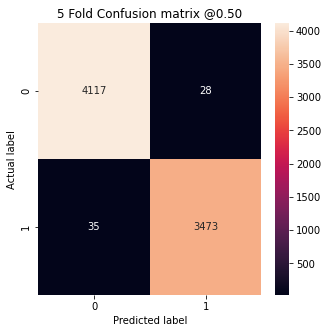

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Legitimate Transactions Detected (True Negatives):  4117
Legitimate Transactions Incorrectly Detected (False Positives):  28
Fraudulent Transactions Missed (False Negatives):  35
Fraudulent Transactions Detected (True Positives):  3473
Total Fraudulent Transactions:  3508


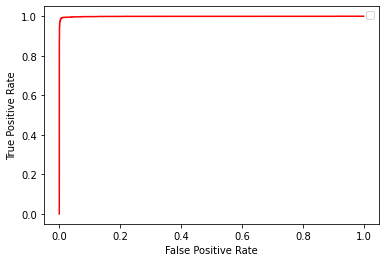

In [57]:
epochs  = 15
k = 1

for train, test in kfold.split(data_pad, y):
    print(f"{k} fold validation:")
    k += 1
    lstm_model = tf.keras.Sequential([
        tf.keras.layers.Embedding(vocab_len, embedding_dim, input_length=max_len, weights=[embedding_matrix], trainable=True),
        tf.keras.layers.LSTM(128,return_sequences=False),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dense(1, activation = 'sigmoid')
    ])

    lstm_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=METRICS)
    history = lstm_model.fit(data_pad[train], np.asarray(y[train]), epochs = epochs, validation_data=(data_pad[test], np.asarray(y[test])), batch_size=128)
    test_evaluation = lstm_model.evaluate(data_pad[test], np.asarray(y[test]), verbose=0, batch_size=256)
    test_predictions = lstm_model.predict(data_pad[test], batch_size=256)
    for name, value in zip(lstm_model.metrics_names, test_evaluation):
        print(name, ': ', value)
    print()
    plot_cm(np.asarray(y[test]), test_predictions, K=k-1)
    fpr, tpr, _ = roc_curve(np.asarray(y[test]), test_predictions)
    plt.plot(fpr, tpr, color = 'r')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    # show the legend
    plt.legend()
    # show the plot
    plt.show()

##### **LSTM with output size of 256**

1 fold validation:
Epoch 1/15
240/240 [==============================] - 13s 40ms/step - loss: 0.1940 - tp: 16159.0000 - fp: 991.0000 - tn: 19837.0000 - fn: 1278.0000 - accuracy: 0.9407 - precision: 0.9422 - recall: 0.9267 - auc: 0.9820 - prc: 0.9806 - val_loss: 0.1124 - val_tp: 3417.0000 - val_fp: 227.0000 - val_tn: 3911.0000 - val_fn: 98.0000 - val_accuracy: 0.9575 - val_precision: 0.9377 - val_recall: 0.9721 - val_auc: 0.9920 - val_prc: 0.9914
Epoch 2/15
240/240 [==============================] - 7s 30ms/step - loss: 0.0966 - tp: 13357.0000 - fp: 381.0000 - tn: 16302.0000 - fn: 572.0000 - accuracy: 0.9689 - precision: 0.9723 - recall: 0.9589 - auc: 0.9916 - prc: 0.9920 - val_loss: 0.0784 - val_tp: 3388.0000 - val_fp: 63.0000 - val_tn: 4075.0000 - val_fn: 127.0000 - val_accuracy: 0.9752 - val_precision: 0.9817 - val_recall: 0.9639 - val_auc: 0.9944 - val_prc: 0.9944
Epoch 3/15
240/240 [==============================] - 7s 30ms/step - loss: 0.0610 - tp: 13607.0000 - fp: 278.0000 - tn:

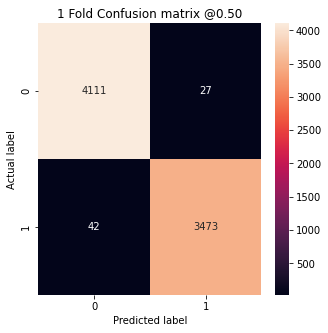

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Legitimate Transactions Detected (True Negatives):  4111
Legitimate Transactions Incorrectly Detected (False Positives):  27
Fraudulent Transactions Missed (False Negatives):  42
Fraudulent Transactions Detected (True Positives):  3473
Total Fraudulent Transactions:  3515


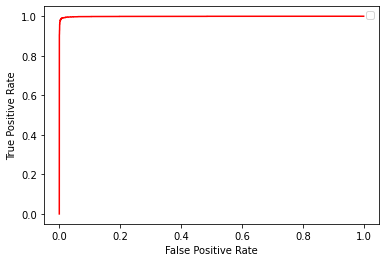

2 fold validation:
Epoch 1/15
240/240 [==============================] - 12s 36ms/step - loss: 0.1907 - tp: 16141.0000 - fp: 990.0000 - tn: 19806.0000 - fn: 1328.0000 - accuracy: 0.9394 - precision: 0.9422 - recall: 0.9240 - auc: 0.9828 - prc: 0.9816 - val_loss: 0.2074 - val_tp: 2900.0000 - val_fp: 43.0000 - val_tn: 4120.0000 - val_fn: 590.0000 - val_accuracy: 0.9173 - val_precision: 0.9854 - val_recall: 0.8309 - val_auc: 0.9788 - val_prc: 0.9800
Epoch 2/15
240/240 [==============================] - 7s 30ms/step - loss: 0.1717 - tp: 12596.0000 - fp: 615.0000 - tn: 16043.0000 - fn: 1358.0000 - accuracy: 0.9355 - precision: 0.9534 - recall: 0.9027 - auc: 0.9786 - prc: 0.9795 - val_loss: 0.0777 - val_tp: 3327.0000 - val_fp: 48.0000 - val_tn: 4115.0000 - val_fn: 163.0000 - val_accuracy: 0.9724 - val_precision: 0.9858 - val_recall: 0.9533 - val_auc: 0.9958 - val_prc: 0.9961
Epoch 3/15
240/240 [==============================] - 7s 30ms/step - loss: 0.0783 - tp: 13459.0000 - fp: 340.0000 - tn

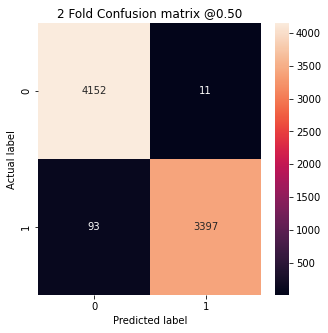

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Legitimate Transactions Detected (True Negatives):  4152
Legitimate Transactions Incorrectly Detected (False Positives):  11
Fraudulent Transactions Missed (False Negatives):  93
Fraudulent Transactions Detected (True Positives):  3397
Total Fraudulent Transactions:  3490


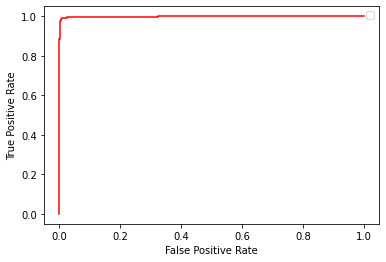

3 fold validation:
Epoch 1/15
240/240 [==============================] - 12s 38ms/step - loss: 0.2022 - tp: 15932.0000 - fp: 872.0000 - tn: 19938.0000 - fn: 1523.0000 - accuracy: 0.9374 - precision: 0.9481 - recall: 0.9127 - auc: 0.9790 - prc: 0.9795 - val_loss: 0.1251 - val_tp: 3182.0000 - val_fp: 51.0000 - val_tn: 4123.0000 - val_fn: 297.0000 - val_accuracy: 0.9545 - val_precision: 0.9842 - val_recall: 0.9146 - val_auc: 0.9902 - val_prc: 0.9908
Epoch 2/15
240/240 [==============================] - 7s 29ms/step - loss: 0.1209 - tp: 13137.0000 - fp: 547.0000 - tn: 16100.0000 - fn: 828.0000 - accuracy: 0.9551 - precision: 0.9600 - recall: 0.9407 - auc: 0.9894 - prc: 0.9895 - val_loss: 0.0643 - val_tp: 3380.0000 - val_fp: 54.0000 - val_tn: 4120.0000 - val_fn: 99.0000 - val_accuracy: 0.9800 - val_precision: 0.9843 - val_recall: 0.9715 - val_auc: 0.9961 - val_prc: 0.9962
Epoch 3/15
240/240 [==============================] - 7s 29ms/step - loss: 0.0538 - tp: 13649.0000 - fp: 225.0000 - tn: 

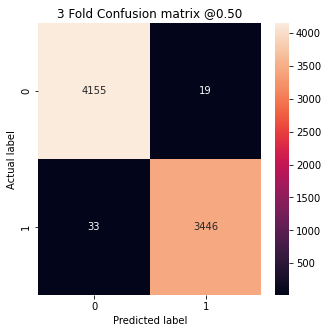

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Legitimate Transactions Detected (True Negatives):  4155
Legitimate Transactions Incorrectly Detected (False Positives):  19
Fraudulent Transactions Missed (False Negatives):  33
Fraudulent Transactions Detected (True Positives):  3446
Total Fraudulent Transactions:  3479


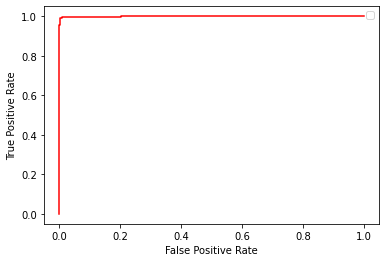

4 fold validation:
Epoch 1/15
240/240 [==============================] - 13s 39ms/step - loss: 0.2096 - tp: 15926.0000 - fp: 974.0000 - tn: 19834.0000 - fn: 1531.0000 - accuracy: 0.9345 - precision: 0.9424 - recall: 0.9123 - auc: 0.9799 - prc: 0.9790 - val_loss: 0.1277 - val_tp: 3268.0000 - val_fp: 146.0000 - val_tn: 4041.0000 - val_fn: 198.0000 - val_accuracy: 0.9551 - val_precision: 0.9572 - val_recall: 0.9429 - val_auc: 0.9885 - val_prc: 0.9890
Epoch 2/15
240/240 [==============================] - 7s 29ms/step - loss: 0.1045 - tp: 13320.0000 - fp: 398.0000 - tn: 16236.0000 - fn: 658.0000 - accuracy: 0.9655 - precision: 0.9710 - recall: 0.9529 - auc: 0.9913 - prc: 0.9916 - val_loss: 0.0729 - val_tp: 3347.0000 - val_fp: 77.0000 - val_tn: 4110.0000 - val_fn: 119.0000 - val_accuracy: 0.9744 - val_precision: 0.9775 - val_recall: 0.9657 - val_auc: 0.9959 - val_prc: 0.9959
Epoch 3/15
240/240 [==============================] - 7s 29ms/step - loss: 0.0599 - tp: 13654.0000 - fp: 278.0000 - tn

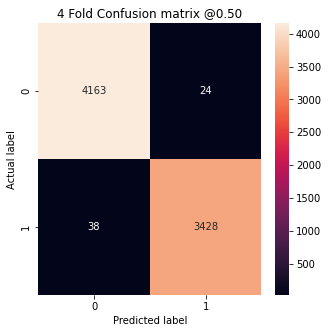

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Legitimate Transactions Detected (True Negatives):  4163
Legitimate Transactions Incorrectly Detected (False Positives):  24
Fraudulent Transactions Missed (False Negatives):  38
Fraudulent Transactions Detected (True Positives):  3428
Total Fraudulent Transactions:  3466


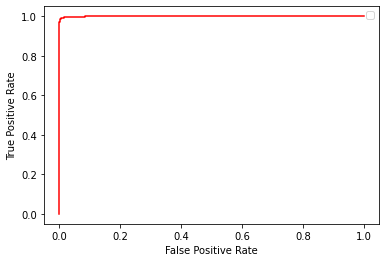

5 fold validation:
Epoch 1/15
240/240 [==============================] - 13s 38ms/step - loss: 0.1863 - tp: 16160.0000 - fp: 960.0000 - tn: 19889.0000 - fn: 1256.0000 - accuracy: 0.9421 - precision: 0.9439 - recall: 0.9279 - auc: 0.9836 - prc: 0.9824 - val_loss: 0.1067 - val_tp: 3333.0000 - val_fp: 128.0000 - val_tn: 4031.0000 - val_fn: 161.0000 - val_accuracy: 0.9622 - val_precision: 0.9630 - val_recall: 0.9539 - val_auc: 0.9919 - val_prc: 0.9919
Epoch 2/15
240/240 [==============================] - 7s 31ms/step - loss: 0.1322 - tp: 13213.0000 - fp: 780.0000 - tn: 15882.0000 - fn: 737.0000 - accuracy: 0.9504 - precision: 0.9443 - recall: 0.9472 - auc: 0.9882 - prc: 0.9867 - val_loss: 0.0780 - val_tp: 3368.0000 - val_fp: 60.0000 - val_tn: 4099.0000 - val_fn: 126.0000 - val_accuracy: 0.9757 - val_precision: 0.9825 - val_recall: 0.9639 - val_auc: 0.9943 - val_prc: 0.9947
Epoch 3/15
240/240 [==============================] - 7s 30ms/step - loss: 0.0523 - tp: 13679.0000 - fp: 221.0000 - tn

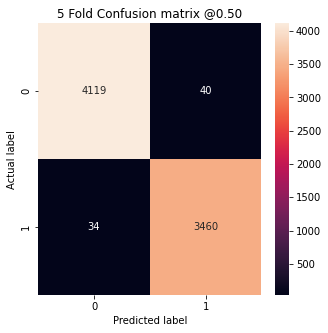

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Legitimate Transactions Detected (True Negatives):  4119
Legitimate Transactions Incorrectly Detected (False Positives):  40
Fraudulent Transactions Missed (False Negatives):  34
Fraudulent Transactions Detected (True Positives):  3460
Total Fraudulent Transactions:  3494


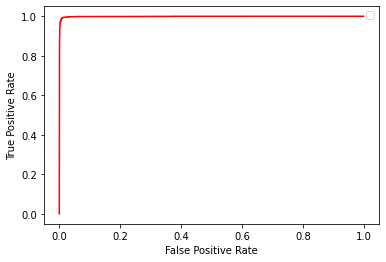

In [58]:
epochs  = 15
k = 1

for train, test in kfold.split(data_pad, y):
    print(f"{k} fold validation:")
    k += 1
    lstm_model = tf.keras.Sequential([
        tf.keras.layers.Embedding(vocab_len, embedding_dim, input_length=max_len, weights=[embedding_matrix], trainable=True),
        tf.keras.layers.LSTM(256,return_sequences=False),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dense(1, activation = 'sigmoid')
    ])

    lstm_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=METRICS)
    history = lstm_model.fit(data_pad[train], np.asarray(y[train]), epochs = epochs, validation_data=(data_pad[test], np.asarray(y[test])), batch_size=128)
    test_evaluation = lstm_model.evaluate(data_pad[test], np.asarray(y[test]), verbose=0, batch_size=256)
    test_predictions = lstm_model.predict(data_pad[test], batch_size=256)
    for name, value in zip(lstm_model.metrics_names, test_evaluation):
        print(name, ': ', value)
    print()
    plot_cm(np.asarray(y[test]), test_predictions, K=k-1)
    fpr, tpr, _ = roc_curve(np.asarray(y[test]), test_predictions)
    plt.plot(fpr, tpr, color = 'r')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    # show the legend
    plt.legend()
    # show the plot
    plt.show()
